In [21]:
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
import random

In [20]:
features_influencers = pd.read_pickle('data/twitter_preprocessed/features_influencers.pkl')
features_targets = pd.read_pickle('data/twitter_preprocessed/features_targets.pkl')
df_edges = pd.read_pickle('data/twitter_preprocessed/edges_100_100.pkl')
df_labels = pd.read_pickle('data/twitter_preprocessed/labels_100_100.pkl')

In [16]:
d_edges = defaultdict(lambda : False)
for (u,v) in zip(df_edges.u, df_edges.v) : 
    d_edges[(u,v)] = True

In [41]:

def feature_twitter(u,v) :
    """
    i:followers_count, 'i:friends_count', 'i:statuses_count', 'i:verified', 'i:gender', 
    'i:d_out', 'i:pagerank', 'i:#2r', 
    'i:high_topic', 'i:med_topic', 'i:low_topic', 
    't:followers_count', 't:friends_count', 't:statuses_count', 't:verified', 't:gender', 
    't:d_out', 't:pagerank', 
    't:high_topic', 't:med_topic', 't:low_topic', 
    'edge'
    """
    fi = np.array(features_influencers.loc[u])
    fv = np.array(features_targets.loc[v])

    return torch.Tensor(np.concatenate([np.zeros(5), fi, np.zeros(8), fv, np.zeros(3), d_edges[(u,v)]], axis = None)).to('cuda')

feature_twitter(19329393, 21172954)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8243, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2780, 1.8433,
        0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')

In [19]:
model_df = torch.load('decision_focused_learning_gpu/models/df_all_200_noCas.pt')
model_2s = torch.load('decision_focused_learning_gpu/models/2s_all_200_noCas.pt')

In [53]:
d_pos = defaultdict(lambda : False)
for (u,v) in zip(df_labels.u, df_labels.v):
    d_pos[(u,v)] = True

In [54]:
influencers = df_labels.groupby('u').count().index
targets = df_labels.groupby('v').count().index

random_pairs = random.sample([k for k in zip(influencers, targets) if not d_pos[k]], 1000)
positive_pairs = list(df_labels.sample(n=1000)[['u','v']].itertuples(index=False, name=None))


In [55]:
results = []
for k in range(1000) :
    u,v = positive_pairs[k]
    dp_pos_df = model_df(feature_twitter(u,v)).item()
    dp_pos_2s = model_2s(feature_twitter(u,v)).item()
    w,t = random_pairs[k]
    dp_rand_df = model_df(feature_twitter(w,t)).item()
    dp_rand_2s = model_2s(feature_twitter(w,t)).item()

    results.append([dp_pos_df, dp_pos_2s, dp_rand_df, dp_rand_2s])


In [58]:
df_results = pd.DataFrame(results)
df_results.columns = ['df model \nv in cascade', '2s model \nv in cascade', 'df model \nv not in cascade', '2s model \nv not in cascade']

Text(0.5, 0.98, 'Difference of predicted DPs in twitter')

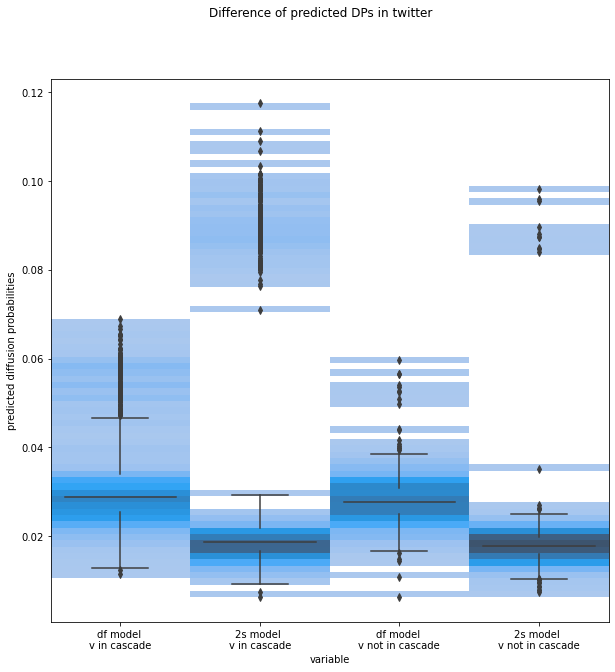

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="variable", y="value", data=pd.melt(df_results), ax = ax)
sns.histplot(x="variable", y="value", data=pd.melt(df_results), ax = ax)
ax.set_ylabel('predicted diffusion probabilities')
fig.suptitle('Difference of predicted DPs in twitter')

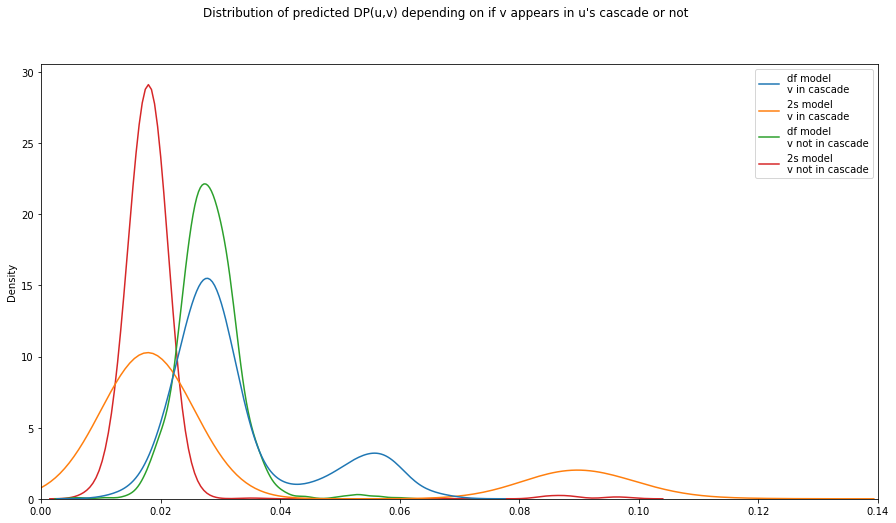

In [69]:
fig, ax = plt.subplots(figsize = (15,8))
sns.kdeplot(data=df_results, ax = ax)
ax.set_xlim(0,0.14)
fig.suptitle("Distribution of predicted DP(u,v) depending on if v appears in u's cascade or not")
plt.show()